### Work Flow
1. Define & formulate a problem
2. Collect data
3. Exploratory data analysis (EDA)
4. Data Preprocessing (DPP) 
5. Select, train, and evaluate models
6. Conclusion

### Define & formulate a problem

Per WHO, stroke is the second leading cause of death globally. This dataset from Kaggle is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, and various diseases. Each observation in the data provides relavant details about the patient.
Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

Attribute Information

1. id: unique identifier
2. gender: "Male" | "Female" | "Other"
3. age: age of the patient
4. hypertension: 0 patient had no hypertension | 1 patient had hypertension
5. heart_disease: 0 patient had no heart disease | 1 patient had a heart disease
6. ever_married: "No" | "Yes"
7. work_type: "children" | "Govt_jov" | "Never_worked" | "Private" | "Self-employed"
8. Residence_type: "Rural" | "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked" | "never smoked" | "smokes" | "Unknown"*
12. stroke: 1 patient had a stroke | 0 patient had no stroke

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient


- STROKE is the target variable in which we will build a model to get predicton on.
- This is a binary classification problem as the classification tasks have two class labels (Stroke | not).
- This analysis is an attempt to identify which machine learning (ML) algorithms can yield better outcomes.

### Collect Data 

In [72]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [73]:
df=pd.read_csv('Documents/healthcare-dataset-stroke-data.csv')
print (f' We have {df.shape[0]} instances with the {df.shape[1]} features and 1 output variable')

 We have 5110 instances with the 12 features and 1 output variable


### EDA

In [74]:
df.duplicated().sum()

0

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [76]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### Dataset at first glance
- it has both numerical and categorical variables
- target variable 'Stroke' is an integer, not as an object
- both 'Hypertension' and 'heart disease" are integer, not as an object
- there are other categorical variables that we need to encode as numeric for model optimization

In [77]:
#find out the values of target variable stroke and their propportion
y = df['stroke']
print(f'Number of patients had a stroke: {y.value_counts()[1]} -> {round(y.value_counts(normalize=True)[1]*100,2)}% \nNumber of patients did not have a stroke: {y.value_counts()[0]} -> {round(y.value_counts(normalize=True)[0]*100,2)}%')


Number of patients had a stroke: 249 -> 4.87% 
Number of patients did not have a stroke: 4861 -> 95.13%


#### Numerical Features

In [78]:
numerical = ['age','avg_glucose_level', 'bmi']
df[numerical].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [79]:
df[numerical].skew()

age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.055340
dtype: float64

- The three numerical features are measured in different scales. Many ML algorithms perform better in standard range scaled numerical variables (like linear models and KNN) while tree models (such as, decision trees,random forest, etc.) work fine with different range numerical features.
- As the skewness result shown above, age has slight left skew, other two features have right tail, positively skewed shape distribution.
- Based on the mean & median score differences, one can expect
  - Slightly left skew on the 'age' (mean: 43.22 & median: 45)
  - Slightly right skew on the 'bmi' (mean: 28.89 & median: 28.10)
  - right skew distribution on the 'avg_glucose_level' (mean: 106.14 & median: 91.88)
- Different scale and skewness will be handled during the modeling step

#### Categorical Features
- the degree of dependency between a categorical variable and the target variable can be measured by using mutual info score.
- higher mutual info scores mean higher degree of dependence and we can get better prediction on the target variable.

In [80]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
'work_type', 'Residence_type', 'smoking_status']

from sklearn.metrics import mutual_info_score
def cat_mut_inf(series):
    return mutual_info_score(series, df['stroke']) 

df_cat = df[categorical].apply(cat_mut_inf) 
df_cat = df_cat.sort_values(ascending=False).to_frame(name='mutual_info_score') 
df_cat

,mutual_info_score
ever_married,0.006950
work_type,0.006825
hypertension,0.005976
heart_disease,0.005897
smoking_status,0.002750
Residence_type,0.000120
gender,0.000051


- As shown above, most of the categorical variables, almost no effect on the target variable. For model improvement, it would be good practice to see the differences on the model between with and without some variables. For the first cut, let's keep these categorical variables in the model.

#### Correlation Matrix

In [81]:
df[numerical].corr()
#There is very small positive correlation between numerical features.

,age,avg_glucose_level,bmi
age,1.000000,0.238171,0.333398
avg_glucose_level,0.238171,1.000000,0.175502
bmi,0.333398,0.175502,1.000000


In [82]:
df[['age','avg_glucose_level','bmi','stroke']].corr()
#The correlations between numerical features with the target variable are very small.

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.238171,0.333398,0.245257
avg_glucose_level,0.238171,1.000000,0.175502,0.131945
bmi,0.333398,0.175502,1.000000,0.042374
stroke,0.245257,0.131945,0.042374,1.000000


#### EDA results
- Age and target variable have weak positive relationship.
- BMI does not have any significant relationship with the target variable.
- Average glucose level's scores on the target have weak relationship with a person's age.

### DPP

In [83]:
#fill null values
#df = df.fillna(df.mean())
df['bmi'].fillna(df['bmi'].mode()[0],inplace=True)

In [84]:
## "smoking_status" has been deleted as it is not a useful data column.
df.drop(["id","smoking_status"], axis=1, inplace=True)

In [85]:
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

In [86]:
le = LabelEncoder()
df["gender"] = le.fit_transform(df["gender"])
df["ever_married"] = le.fit_transform(df["ever_married"])
df["Residence_type"] = le.fit_transform(df["Residence_type"])

In [87]:
df = pd.get_dummies(df, columns=["work_type"])

In [88]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.7,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0


### Select, train, and evaluate models

In [89]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [91]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [92]:
model_df = pd.DataFrame(columns=["Model Name","Accuracy Score"])

In [93]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predictions_dtc = dtc.predict(X_test)
score = accuracy_score(y_test, predictions_dtc)
print(score)

0.8992294013040901


In [94]:
new_row = {"Model Name":"Decision Tree Classifier", "Accuracy Score":score}
model_df = model_df.append(new_row, ignore_index=True)

In [95]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions_rfc = rfc.predict(X_test)
score = accuracy_score(y_test, predictions_rfc)
print(score)

0.941315945465323


In [96]:
new_row = {"Model Name":"Random Forest Classifier", "Accuracy Score":score}
model_df = model_df.append(new_row, ignore_index=True)

In [97]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
predictions_knc = knc.predict(X_test)
score = accuracy_score(y_test, predictions_knc)
print(score)

0.941908713692946


In [98]:
new_row = {"Model Name":"KNeighbors Classifier", "Accuracy Score":score}
model_df = model_df.append(new_row, ignore_index=True)

In [99]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions_gnb = gnb.predict(X_test)
score = accuracy_score(y_test, predictions_gnb)
print(score)

0.2857142857142857


In [100]:
new_row = {"Model Name":"GaussianNB","Accuracy Score":score}
model_df = model_df.append(new_row, ignore_index=True)

In [101]:
model_df.sort_values("Accuracy Score", ascending=False)

,Model Name,Accuracy Score
2,KNeighbors Classifier,0.941909
1,Random Forest Classifier,0.941316
0,Decision Tree Classifier,0.899229
3,GaussianNB,0.285714


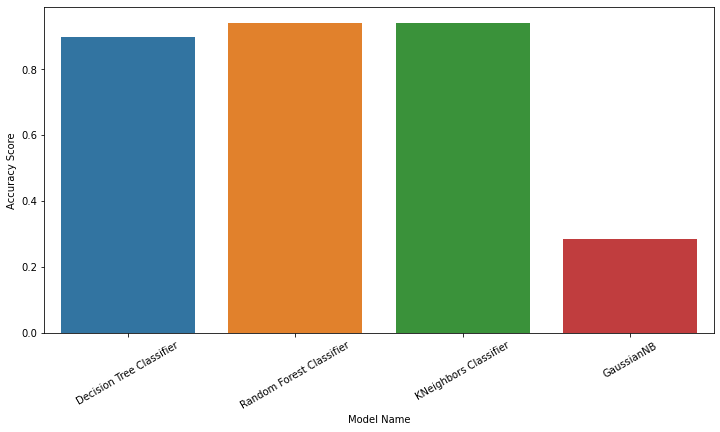

In [102]:
plt.figure(figsize=(12,6))
sns.barplot(x=model_df["Model Name"], y=model_df["Accuracy Score"])
plt.xticks(rotation=30)
plt.show()

### Conclusion
As the above results have shown, kNN and Random Forest classifiers yield better results for this type of data.